In [1]:
from aicsimageio import AICSImage
import stackview
import skimage
from skimage.measure import label
from skimage.segmentation import clear_border
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import roifile
import os
from typing import List, Tuple

In [46]:
data_name = "Neurons_D14_Control_Axons_1"
file_path = "Z:\\SK\\20250605\\" + data_name + "\\" + data_name + "_MMStack_Pos0.ome.tif"
roi_path = "Z:\\SK\\20250605\\" + data_name + "_RoiSet.zip"
# ImageJ ROIs of points that were not bleached.  These will be used to control for photo-bleaching
roi_control_path = "Z:\\SK\\20250605\\" + data_name + "_Control_RoiSet.zip"

In [47]:
img = AICSImage(file_path)
metadata = img.metadata
delta_t = metadata.images[0].pixels.time_increment
delta_x = metadata.images[0].pixels.physical_size_x
delta_y = metadata.images[0].pixels.physical_size_y
img.shape

(100, 1, 1, 2048, 2048)

In [48]:
# data is returned as a 5d array in the shape t, c, z, x, y.  Since we do not have c or z, remove them here cheaply
img_data = np.squeeze(img.data, axis=(1, 2))
# stackview.slice(img_data, slice_number=200, zoom_factor=0.3, continuous_update=True)

In [49]:
def read_imagej_rois(file_path):
    """
    Reads ImageJ ROI files (.roi or .zip) and extracts ROI information,
    including x, y coordinates.

    Args:
        file_path (str): The path to the ImageJ ROI file (e.g., 'my_rois.roi'
                         or 'my_rois.zip').

    Returns:
        list of dict: A list where each dictionary represents an ROI.
                      Each dictionary contains at least 'label' and 'coordinates'.
                      The structure of 'coordinates' depends on the ROI type.
                      Returns an empty list if no ROIs are found or file is invalid.
    """
    roi_data = []

    try:
        # roifile.ImagejRoi.fromfile() is the correct method for reading a single .roi file.
        # For .zip files, it correctly detects and returns a list of ROI objects.
        # This simplifies the initial reading step significantly.
        rois = roifile.ImagejRoi.fromfile(file_path)

        # Ensure 'rois' is always a list for consistent processing
        if not isinstance(rois, list):
            rois = [rois] # Wrap single ROI object in a list

        for roi_obj in rois:
            coords = get_roi_coordinates(roi_obj)
            if coords is not None:
                # Use roi_obj.name for label, fallback if name is not explicitly set
                label = roi_obj.name if roi_obj.name else f"ROI_{rois.index(roi_obj) + 1}"
                # If it's a single .roi file and no name, use filename without extension
                if not roi_obj.name and len(rois) == 1:
                    label = os.path.basename(file_path).replace('.roi', '')

                roi_data.append({
                    'label': label,
                    'roi_type': roi_obj.roitype.name, # Use .name for string representation
                    'coordinates': coords
                })

    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")
        return []

    return roi_data

def get_roi_coordinates(roi_obj):
    """
    Extracts coordinates from a roifile.ImagejRoi object based on its type.

    Args:
        roi_obj (roifile.ImagejRoi): An ROI object read by roifile.

    Returns:
        numpy.ndarray or None: A NumPy array of (x, y) coordinates for polygon,
                               freehand, line, or point ROIs.
                               For rectangular or oval ROIs, it returns the bounding box.
                               Returns None for unsupported ROI types or if coordinates are not applicable.
    """
    roi_type = roi_obj.roitype

    if roi_type in [roifile.ROI_TYPE.POLYGON, 
                    roifile.ROI_TYPE.FREELINE, roifile.ROI_TYPE.POINT]:
        # For polygon, freehand, freehandline, and point, the 'points' attribute contains vertices
        # Or, the roi_obj itself can be iterated if it's a point ROI.
        # The coordinates() method is generally the way to get geometric points.
        return roi_obj.coordinates()
    elif roi_type in [roifile.ROI_TYPE.RECT, roifile.ROI_TYPE.OVAL]:
        # Rectangular/Oval ROI: defined by bounding box [left, top, right, bottom]
        # Coordinates can be represented as top-left and bottom-right corners
        return np.array([[roi_obj.left, roi_obj.top],
                         [roi_obj.right, roi_obj.bottom]])
    elif roi_type == roifile.ROI_TYPE.LINE:
        # Line ROI: x1, y1, x2, y2
        return np.array([[roi_obj.x1, roi_obj.y1],
                         [roi_obj.x2, roi_obj.y2]])
    else:
        print(f"Warning: ROI type '{roi_type.name}' ({roi_type}) not explicitly handled for coordinate extraction. "
              "Check roifile documentation for how to access its specific data. ROI Label: {roi_obj.name}")
        return None
        


In [63]:
def create_circular_mask(shape: Tuple[int, int], center: Tuple[int, int], radius: float) -> np.ndarray:
    """
    Create a circular mask for the given shape and center coordinates.
    
    Args:
        shape: Shape of the image (height, width)
        center: Center coordinates (x, y)
        radius: Radius of the circle
    
    Returns:
        Boolean mask where True indicates pixels inside the circle
    """
    y, x = np.ogrid[:shape[0], :shape[1]]
    cx, cy = center
    
    # Calculate distance from center
    distance = np.sqrt((x - cx)**2 + (y - cy)**2)
    
    # Create circular mask
    mask = distance <= radius
    return mask

def extract_circular_intensities(image: np.ndarray, coordinates: List[Tuple[int, int]], 
                               radius: float = 5.0) -> np.ndarray:
    """
    Extract mean intensities from circular regions around given coordinates.
    
    Args:
        image: 3D numpy array of shape (t, x, y)
        coordinates: List of (x, y) coordinate tuples
        radius: Radius of the circular region
    
    Returns:
        2D numpy array of shape (n_coordinates, n_timepoints) containing mean intensities
    """
    n_timepoints, height, width = image.shape
    n_coords = len(coordinates)
    
    # Initialize result array
    intensities = np.zeros((n_coords, n_timepoints))
    
    # Process each coordinate
    for coord_idx, (x, y) in enumerate(coordinates):
        # Check if coordinates are within image bounds
        if x < 0 or x >= width or y < 0 or y >= height:
            print(f"Warning: Coordinate ({x}, {y}) is outside image bounds")
            intensities[coord_idx, :] = np.nan
            continue
        
        # Create circular mask
        mask = create_circular_mask((height, width), (x, y), radius)
        
        # Check if mask contains any pixels
        if not np.any(mask):
            print(f"Warning: No pixels found in circle at ({x}, {y}) with radius {radius}")
            intensities[coord_idx, :] = np.nan
            continue
        
        # Extract mean intensity for each time point
        for t in range(n_timepoints):
            masked_pixels = image[t][mask]
            intensities[coord_idx, t] = np.mean(masked_pixels)
    
    return intensities

def plot_intensity_timeseries(intensities: np.ndarray, coordinates: List[Tuple[int, int]], 
                            radius: float, time_interval: float = 1.0, figsize: Tuple[int, int] = (12, 8)):
    """
    Plot intensity time series for each coordinate, normalized by the first time point.
    
    Args:
        intensities: 2D array of shape (n_coordinates, n_timepoints)
        coordinates: List of (x, y) coordinate tuples
        radius: Radius used for extraction
        time_interval: Time interval between data points in seconds
        figsize: Figure size tuple
    """
    n_coords, n_timepoints = intensities.shape
    time_points = np.arange(n_timepoints) * time_interval
    
    plt.figure(figsize=figsize)
    
    # Plot each coordinate's time series
    for i, (x, y) in enumerate(coordinates):
        # Normalize by the first time point
        #first_point = intensities[i, 0]
        #if not np.isnan(first_point) and first_point != 0:
        #    normalized_intensities = intensities[i, :] / first_point
        #else:
        #    # Handle edge case where first point is NaN or zero
        #    normalized_intensities = np.full_like(intensities[i, :], np.nan)
            
        plt.plot(time_points, intensities[i, :], 
                marker='o', markersize=3, linewidth=1.5,
                label=f'({x}, {y})')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Intensity (F/F₀)')
    plt.title(f'Normalized Intensity Time Series (Radius: {radius})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def analyze_circular_regions(image: np.ndarray, coordinates: List[Tuple[int, int]], 
                           radius: float = 5.0, time_interval: float = 1.0, plot: bool = True) -> np.ndarray:
    """
    Complete analysis pipeline: extract intensities and optionally plot results.
    
    Args:
        image: 3D numpy array of shape (t, x, y)
        coordinates: List of (x, y) coordinate tuples
        radius: Radius of the circular region
        time_interval: Time interval between data points in seconds
        plot: Whether to create a plot
    
    Returns:
        2D numpy array of intensities
    """
    print(f"Analyzing {len(coordinates)} coordinates with radius {radius}")
    print(f"Image shape: {image.shape}")
    
    # Extract intensities
    intensities = extract_circular_intensities(image, coordinates, radius)
    
    # Print summary statistics
    print(f"\nIntensity Statistics:")
    print(f"Shape: {intensities.shape}")
    print(f"Mean across all: {np.nanmean(intensities):.3f}")
    print(f"Std across all: {np.nanstd(intensities):.3f}")
    print(f"Min: {np.nanmin(intensities):.3f}")
    print(f"Max: {np.nanmax(intensities):.3f}")
    
    # Plot if requested
    if plot:
        plot_intensity_timeseries(intensities, coordinates, radius, time_interval)
    
    return intensities

def normalized_intensity_timeseries(intensities: np.ndarray, 
                                   number_of_first_frames_to_set_to_one: int) -> np.ndarray:
    """
    Normalize each row of a 2D intensity array by the average of the first n frames.
    
    Parameters:
    intensities (np.ndarray): 2D numpy array where each row represents a timeseries
                             (e.g., shape (200, 8) means 200 timepoints, 8 series)
    number_of_first_frames_to_set_to_one (int): Number of first frames to use for 
                                               calculating the baseline average
    
    Returns:
    np.ndarray: Normalized intensity array with same shape as input
    """
    # Input validation
    if len(intensities.shape) != 2:
        raise ValueError("intensities must be a 2D array")
    
    if number_of_first_frames_to_set_to_one <= 0:
        raise ValueError("number_of_first_frames_to_set_to_one must be positive")
    
    if number_of_first_frames_to_set_to_one > intensities.shape[0]:
        raise ValueError(f"number_of_first_frames_to_set_to_one ({number_of_first_frames_to_set_to_one}) "
                        f"cannot exceed number of timepoints ({intensities.shape[0]})")
    
    # Calculate baseline average for each column (timeseries)
    # Take the first n rows and compute mean along axis 0 (across timepoints)
    baseline_averages = np.mean(intensities[:, :number_of_first_frames_to_set_to_one], axis=1)
    
    # Check for zero averages to avoid division by zero
    if np.any(baseline_averages == 0):
        raise ValueError("Some baseline averages are zero, cannot normalize")
    
    # Normalize each column by its baseline average
    # Broadcasting will handle the division across all rows
    normalized = (intensities.T / baseline_averages).T
    
    return normalized



In [42]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_exponential_to_average(normalized_array: np.ndarray, 
                              fit_type: str = 'decay',
                              return_stats: bool = False):
    """
    Fit the average of a normalized array to an exponential function.
    
    Parameters:
    normalized_array (np.ndarray): 2D normalized intensity array with shape (n_series, n_timepoints)
                                  e.g., (8, 200) where 8 is number of timeseries, 200 is timepoints
    fit_type (str): Type of exponential fit - 'decay', 'growth', or 'general'
    return_stats (bool): If True, return additional fit statistics
    
    Returns:
    tuple: (fitted_parameters, time_points, fitted_curve, [optional: fit_stats])
    
    a: amplitude/scaling factor
    b: rate constant (positive for growth, negative for decay)
    c: offset/baseline level
    """
    
    # Calculate average across all rows (timeseries) - axis=0 averages across series
    average_signal = np.mean(normalized_array, axis=0)
    
    # Create time points (assuming unit time steps)
    time_points = np.arange(len(average_signal))
    
    # Define exponential functions
    def exponential_decay(t, a, b, c):
        """a * exp(-b * t) + c"""
        return a * np.exp(-b * t) + c
    
    def exponential_growth(t, a, b, c):
        """a * exp(b * t) + c"""
        return a * np.exp(b * t) + c
    
    def exponential_general(t, a, b, c):
        """a * exp(b * t) + c (b can be positive or negative)"""
        return a * np.exp(b * t) + c
    
    # Select function and initial parameters based on fit_type
    if fit_type == 'decay':
        func = exponential_decay
        # Initial guess: start high, decay to baseline
        p0 = [average_signal[0] - average_signal[-1], 0.01, average_signal[-1]]
    elif fit_type == 'growth':
        func = exponential_growth
        # Initial guess: start low, grow to final value
        p0 = [average_signal[-1] - average_signal[0], 0.01, average_signal[0]]
    elif fit_type == 'general':
        func = exponential_general
        # Initial guess: let it figure out growth or decay
        if average_signal[-1] > average_signal[0]:
            p0 = [average_signal[-1] - average_signal[0], 0.01, average_signal[0]]
        else:
            p0 = [average_signal[0] - average_signal[-1], -0.01, average_signal[-1]]
    else:
        raise ValueError("fit_type must be 'decay', 'growth', or 'general'")
    
    try:
        # Perform the fit
        popt, pcov = curve_fit(func, time_points, average_signal, p0=p0, maxfev=10000)
        
        # Generate fitted curve
        fitted_curve = func(time_points, *popt)
        
        # Calculate fit statistics if requested
        if return_stats:
            # R-squared
            ss_res = np.sum((average_signal - fitted_curve) ** 2)
            ss_tot = np.sum((average_signal - np.mean(average_signal)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Parameter errors (standard deviation)
            param_errors = np.sqrt(np.diag(pcov))
            
            # Root mean square error
            rmse = np.sqrt(np.mean((average_signal - fitted_curve) ** 2))
            
            fit_stats = {
                'r_squared': r_squared,
                'rmse': rmse,
                'parameter_errors': param_errors,
                'covariance_matrix': pcov
            }
            
            return popt, time_points, fitted_curve, average_signal, fit_stats
        
        return popt, time_points, fitted_curve, average_signal
        
    except Exception as e:
        raise RuntimeError(f"Fitting failed: {str(e)}")

def plot_exponential_fit(time_points, average_signal, fitted_curve, parameters, 
                        fit_type='decay', fit_stats=None):
    """
    Plot the original data and exponential fit.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, average_signal, 'bo-', label='Average Signal', markersize=4)
    plt.plot(time_points, fitted_curve, 'r-', label=f'Exponential Fit ({fit_type})', linewidth=2)
    
    # Add parameter info to plot
    if fit_type == 'decay':
        plt.title(f'Exponential Decay Fit: y = {parameters[0]:.3f} * exp(-{parameters[1]:.3f} * t) + {parameters[2]:.3f}')
    elif fit_type == 'growth':
        plt.title(f'Exponential Growth Fit: y = {parameters[0]:.3f} * exp({parameters[1]:.3f} * t) + {parameters[2]:.3f}')
    else:
        sign = '+' if parameters[1] >= 0 else ''
        plt.title(f'Exponential Fit: y = {parameters[0]:.3f} * exp({sign}{parameters[1]:.3f} * t) + {parameters[2]:.3f}')
    
    plt.xlabel('Time Points')
    plt.ylabel('Normalized Intensity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add fit statistics if available
    if fit_stats:
        textstr = f'R² = {fit_stats["r_squared"]:.4f}\nRMSE = {fit_stats["rmse"]:.4f}'
        plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return plt.gcf()

def exponential(x, parameters):
    return parameters[0] * np.exp(-parameters[1] * x) + parameters[2]

def correct_for_bleaching(input_array: np.ndarray, parameters):
    correction_array=np.ones((1, input_array.shape[1]))
    for x in range(input_array.shape[1]) :
        correction_array[0, x] = exponential(x, parameters)
    result = input_array / correction_array
    return result, correction_array
    

In [ ]:
# Example usage
if __name__ == "__main__":
    # Create sample normalized data (simulating exponential decay)
    # Now with shape (n_series, n_timepoints) = (8, 200)
    np.random.seed(42)
    n_timepoints = 200
    n_series = 8
    
    # Generate synthetic data with exponential decay + noise
    t = np.arange(n_timepoints)
    true_signal = 2.0 * np.exp(-0.03 * t) + 0.5  # True exponential decay
    
    # Add some variation across different series and noise
    sample_data = np.zeros((n_series, n_timepoints))
    for i in range(n_series):
        # Each series has slight variations
        variation = np.random.normal(1.0, 0.1)
        noise = np.random.normal(0, 0.05, n_timepoints)
        sample_data[i, :] = true_signal * variation + noise
    
    print("Sample data shape:", sample_data.shape)
    print("Data range:", np.min(sample_data), "to", np.max(sample_data))
    
    # Fit exponential decay
    try:
        params, time_pts, fit_curve, avg_signal, stats = fit_exponential_to_average(
            sample_data, fit_type='decay', return_stats=True
        )
        
        print(f"\nFit Results:")
        print(f"Parameters [a, b, c]: {params}")
        print(f"Function: y = {params[0]:.3f} * exp(-{params[1]:.3f} * t) + {params[2]:.3f}")
        print(f"R-squared: {stats['r_squared']:.4f}")
        print(f"RMSE: {stats['rmse']:.4f}")
        
        # Create and show plot
        fig = plot_exponential_fit(time_pts, avg_signal, fit_curve, params, 'decay', stats)
        plt.show()
        
        # Compare with true parameters
        print(f"\nTrue parameters were: a=2.0, b=0.03, c=0.5")
        print(f"Fitted parameters: a={params[0]:.3f}, b={params[1]:.3f}, c={params[2]:.3f}")
        
    except Exception as e:
        print(f"Error during fitting: {e}")

In [51]:
rois = read_imagej_rois(roi_path)
coordinates = []
for roi in rois:
    coordinates.append((int(roi['coordinates'][0][0]), int(roi['coordinates'][0][1])))
print (coordinates)

control_rois = read_imagej_rois(roi_control_path)
control_coordinates = []
for control_roi in control_rois:
    control_coordinates.append((int(control_roi['coordinates'][0][0]), int(control_roi['coordinates'][0][1])))
print(control_coordinates)

[(828, 1480), (798, 1571), (453, 1627), (1076, 1151), (1449, 639), (832, 451), (1401, 1584), (1346, 1701), (1798, 1589), (1852, 1143)]
[(570, 818), (496, 224), (714, 168), (1068, 1088), (876, 908), (1300, 1782), (1528, 1270), (1884, 1244), (572, 1678), (354, 1580), (1202, 1538)]


[ 2.58950111e+02  7.09488369e-06 -2.57942531e+02]


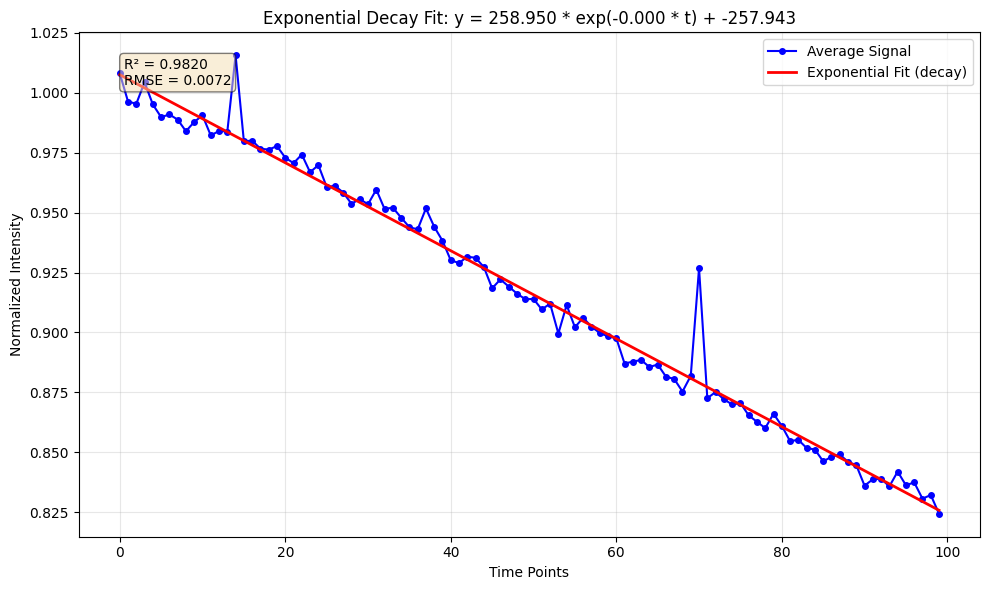

In [52]:
# Analyze controls, i.e. photo-bleaching just do to the imaging itself
raw_control_intensities = extract_circular_intensities(img_data, control_coordinates, 6)
control_intensities = normalized_intensity_timeseries(raw_control_intensities, 3);

params, time_pts, fit_curve, avg_signal, stats = fit_exponential_to_average(control_intensities, 'decay', True)
print(params)
fig = plot_exponential_fit(time_pts, avg_signal, fit_curve, params, 'decay', stats)
plt.show()
#print(control_intensities[0, :])
#average_signal = np.mean(raw_control_intensities, axis=0)
#print(average_signal)

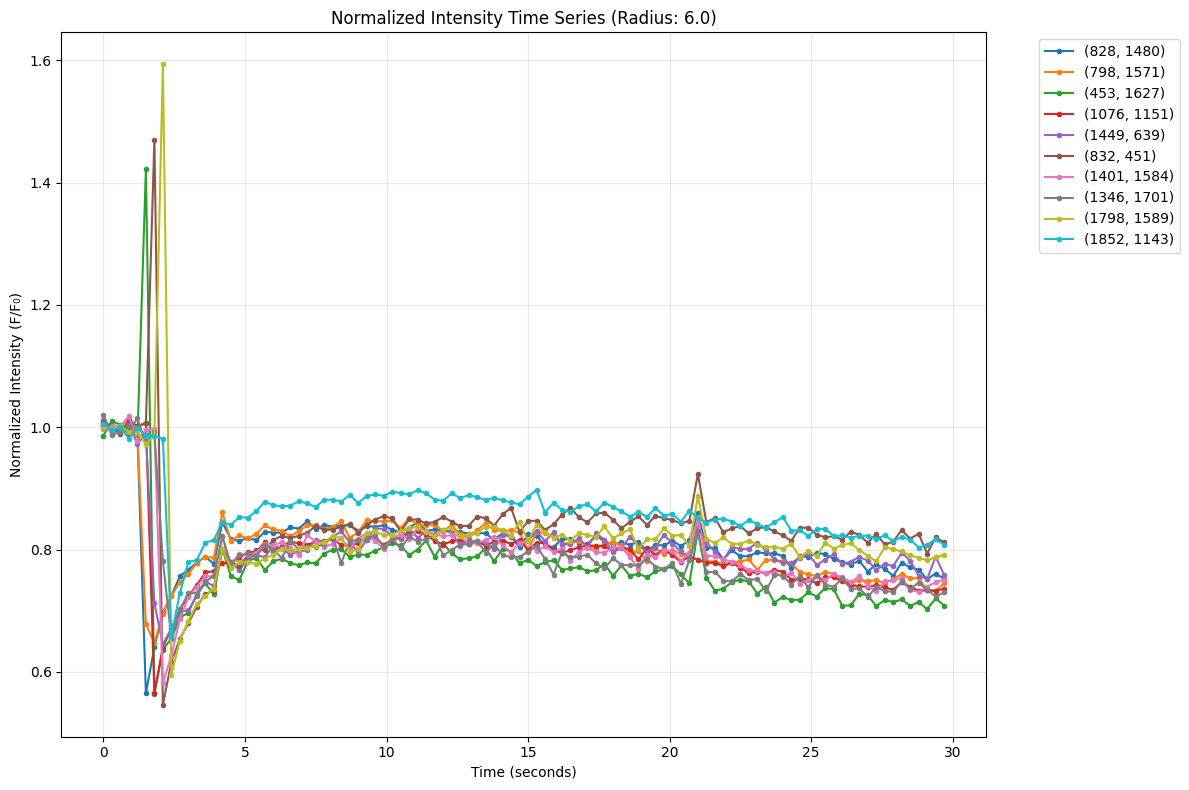

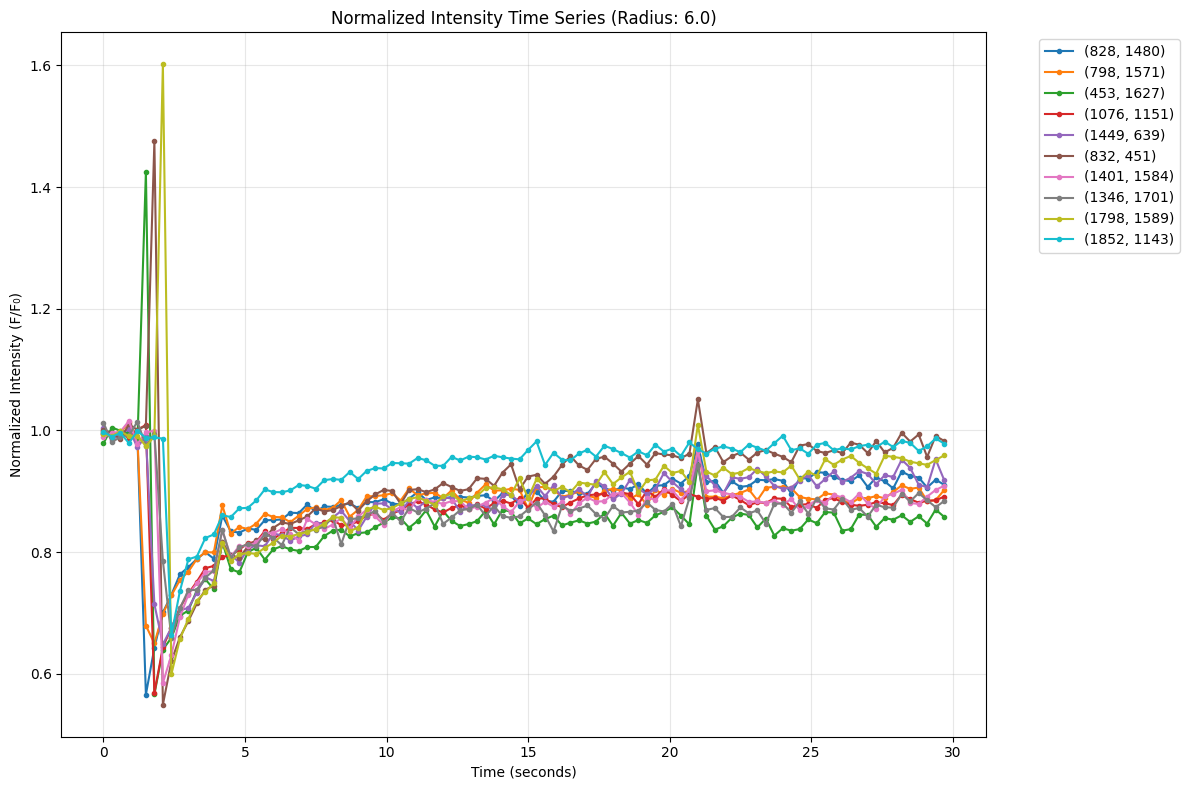

In [68]:
# Run analysis
intensities = extract_circular_intensities(img_data, coordinates, radius=6.0)
intensities_n = normalized_intensity_timeseries(intensities, 3)
bleach_corrected, tmp2 = correct_for_bleaching(intensities_n, params);

# Plot uncorrected data
plot_intensity_timeseries(intensities_n, coordinates, radius=6.0, time_interval=delta_t / 1000)
#Plot data corrected for bleach
plot_intensity_timeseries(bleach_corrected, coordinates, radius=6.0, time_interval=delta_t / 1000)

#intensities = analyze_circular_regions(img_data, coordinates, radius=6.0, time_interval= delta_t / 1000)  # Read from Image metadata)
    
# You can also access individual time series
#print(f"\nFirst coordinate time series (first 10 points):")
#print(bleach_corrected)

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_recovery_function(intensity_array: np.ndarray, 
                         return_stats: bool = False,
                         plot_results: bool = False):
    """
    Fit recovery data to F(t) = A * (1 - exp(-t/τ)) starting from the lowest intensity point.
    
    Parameters:
    intensity_array (np.ndarray): 2D array of shape (x, y) where x is series number,
                                 y is intensity as function of time
    return_stats (bool): If True, return additional fit statistics
    plot_results (bool): If True, create plots showing fits
    
    Returns:
    dict: Contains fitted parameters and statistics for each series
    """
    
    if len(intensity_array.shape) != 2:
        raise ValueError("Input must be a 2D array")
    
    n_series, n_timepoints = intensity_array.shape
    
    # Define the recovery function
    def recovery_function(t, A, tau):
        """F(t) = A * (1 - exp(-t/tau))"""
        return A * (1 - np.exp(-t / tau))
    
    results = {}
    
    for series_idx in range(n_series):
        try:
            # Get intensity data for this series
            intensity_data = intensity_array[series_idx, :]
            
            # Find the index of minimum intensity (start of recovery)
            min_idx = np.argmin(intensity_data)
            
            # Extract data starting from minimum intensity
            recovery_data = intensity_data[min_idx:]
            recovery_timepoints = np.arange(len(recovery_data))
            
            # Shift data so it starts from zero (subtract minimum value)
            min_intensity = recovery_data[0]
            shifted_data = recovery_data - min_intensity
            
            # Initial parameter guesses
            # A: approximate plateau height (max - min of recovery data)
            A_guess = np.max(shifted_data) if np.max(shifted_data) > 0 else 1.0
            
            # tau: rough estimate based on when we reach ~63% of plateau
            # Find where signal reaches 63% of max
            target_value = 0.63 * A_guess
            tau_guess = 1.0
            if A_guess > 0:
                # Find approximate tau from data
                above_target = np.where(shifted_data >= target_value)[0]
                if len(above_target) > 0:
                    tau_guess = float(above_target[0])
                else:
                    tau_guess = len(recovery_timepoints) / 3.0
            
            # Set reasonable bounds for parameters
            # A should be positive and not too much larger than data range
            A_bounds = (0, 5 * A_guess if A_guess > 0 else 10)
            # tau should be positive and reasonable given time scale
            tau_bounds = (0.1, 10 * len(recovery_timepoints))
            
            bounds = ([A_bounds[0], tau_bounds[0]], 
                     [A_bounds[1], tau_bounds[1]])
            
            # Perform the fit
            popt, pcov = curve_fit(
                recovery_function, 
                recovery_timepoints, 
                shifted_data,
                p0=[A_guess, tau_guess],
                bounds=bounds,
                maxfev=5000
            )
            
            A_fit, tau_fit = popt
            
            # Generate fitted curve
            fitted_curve = recovery_function(recovery_timepoints, A_fit, tau_fit)
            
            # Add back the minimum intensity to get absolute values
            fitted_curve_absolute = fitted_curve + min_intensity
            
            # Calculate fit statistics
            ss_res = np.sum((shifted_data - fitted_curve) ** 2)
            ss_tot = np.sum((shifted_data - np.mean(shifted_data)) ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            rmse = np.sqrt(np.mean((shifted_data - fitted_curve) ** 2))
            param_errors = np.sqrt(np.diag(pcov))
            
            # Store results
            series_result = {
                'A': A_fit,
                'tau': tau_fit,
                'min_intensity': min_intensity,
                'min_index': min_idx,
                'r_squared': r_squared,
                'rmse': rmse,
                'parameter_errors': param_errors,
                'recovery_timepoints': recovery_timepoints,
                'recovery_data': recovery_data,
                'fitted_curve': fitted_curve_absolute,
                'shifted_data': shifted_data,
                'fitted_curve_shifted': fitted_curve
            }
            
            if return_stats:
                series_result.update({
                    'covariance_matrix': pcov,
                    'initial_guess': [A_guess, tau_guess],
                    'bounds_used': bounds
                })
            
            results[f'series_{series_idx}'] = series_result
            
        except Exception as e:
            print(f"Warning: Fitting failed for series {series_idx}: {str(e)}")
            results[f'series_{series_idx}'] = {
                'error': str(e),
                'A': np.nan,
                'tau': np.nan,
                'r_squared': np.nan
            }
    
    # Create plots if requested
    if plot_results:
        plot_recovery_fits(intensity_array, results)
    
    return results

def plot_recovery_fits(intensity_array, results, max_plots=6):
    """Plot the recovery fits for visualization"""
    n_series = intensity_array.shape[0]
    n_plots = min(n_series, max_plots)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(n_plots):
        ax = axes[i]
        series_key = f'series_{i}'
        
        if series_key not in results or 'error' in results[series_key]:
            ax.text(0.5, 0.5, f'Series {i}\nFit Failed', 
                   ha='center', va='center', transform=ax.transAxes)
            continue
        
        result = results[series_key]
        
        # Plot original data
        original_time = np.arange(intensity_array.shape[1])
        ax.plot(original_time, intensity_array[i, :], 'b.-', alpha=0.7, 
                label='Original Data', markersize=3)
        
        # Highlight recovery portion
        min_idx = result['min_index']
        recovery_time = original_time[min_idx:]
        
        ax.plot(recovery_time, result['fitted_curve'], 'r-', 
                linewidth=2, label='Recovery Fit')
        
        # Mark minimum point
        ax.axvline(x=min_idx, color='gray', linestyle='--', alpha=0.5, 
                  label='Recovery Start')
        
        # Add fit parameters to plot
        A, tau = result['A'], result['tau']
        r2 = result['r_squared']
        
        textstr = f'A = {A:.2f}\nτ = {tau:.2f}\nR² = {r2:.3f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.8), fontsize=9)
        
        ax.set_title(f'Series {i}')
        ax.set_xlabel('Time Points')
        ax.set_ylabel('Intensity')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig

def summarize_fits(results):
    """Print a summary of all fits"""
    print("="*60)
    print("RECOVERY FUNCTION FIT SUMMARY")
    print("="*60)
    print(f"{'Series':<8} {'A (Plateau)':<12} {'τ (Time)':<10} {'R²':<8} {'Status'}")
    print("-"*60)
    
    successful_fits = 0
    A_values = []
    tau_values = []
    
    for series_key, result in results.items():
        series_num = series_key.split('_')[1]
        
        if 'error' in result:
            print(f"{series_num:<8} {'Failed':<12} {'Failed':<10} {'--':<8} Error")
        else:
            A, tau, r2 = result['A'], result['tau'], result['r_squared']
            print(f"{series_num:<8} {A:<12.3f} {tau:<10.3f} {r2:<8.3f} OK")
            successful_fits += 1
            A_values.append(A)
            tau_values.append(tau)
    
    if successful_fits > 0:
        print("-"*60)
        print(f"Successful fits: {successful_fits}/{len(results)}")
        print(f"Average A: {np.mean(A_values):.3f} ± {np.std(A_values):.3f}")
        print(f"Average τ: {np.mean(tau_values):.3f} ± {np.std(tau_values):.3f}")



In [ ]:
# Example usage and testing
if __name__ == "__main__":
    # Generate synthetic recovery data
    np.random.seed(42)
    n_series = 6
    n_timepoints = 50
    
    # Create synthetic data with recovery pattern
    synthetic_data = np.zeros((n_series, n_timepoints))
    
    for i in range(n_series):
        # True parameters for each series
        true_A = 80 + np.random.normal(0, 10)  # Plateau around 80
        true_tau = 8 + np.random.normal(0, 2)   # Time constant around 8
        baseline = 20 + np.random.normal(0, 5)  # Baseline around 20
        
        # Recovery starts at random point (simulating bleaching then recovery)
        recovery_start = np.random.randint(5, 15)
        
        time_points = np.arange(n_timepoints)
        
        # Before recovery: high intensity with some decay
        pre_recovery = baseline + true_A * np.exp(-(time_points[:recovery_start])/5)
        
        # Recovery phase: exponential recovery
        recovery_time = time_points[recovery_start:] - recovery_start
        recovery_phase = baseline + true_A * (1 - np.exp(-recovery_time / true_tau))
        
        # Combine phases
        full_signal = np.concatenate([pre_recovery, recovery_phase])
        
        # Add noise
        noise = np.random.normal(0, 3, n_timepoints)
        synthetic_data[i, :] = full_signal + noise
    
    print("Generated synthetic recovery data")
    print(f"Data shape: {synthetic_data.shape}")
    print()
    
    # Fit the recovery functions
    results = fit_recovery_function(
        synthetic_data, 
        return_stats=True, 
        plot_results=True
    )
    
    # Print summary
    summarize_fits(results)
    
    # Show individual series details
    print("\nDetailed Results for First 3 Series:")
    for i in range(min(3, len(results))):
        series_key = f'series_{i}'
        if series_key in results and 'error' not in results[series_key]:
            result = results[series_key]
            print(f"\nSeries {i}:")
            print(f"  Plateau (A): {result['A']:.3f} ± {result['parameter_errors'][0]:.3f}")
            print(f"  Time constant (τ): {result['tau']:.3f} ± {result['parameter_errors'][1]:.3f}")
            print(f"  Recovery starts at index: {result['min_index']}")
            print(f"  Minimum intensity: {result['min_intensity']:.3f}")
            print(f"  R²: {result['r_squared']:.4f}")
    
    plt.show()

RECOVERY FUNCTION FIT SUMMARY
Series   A (Plateau)  τ (Time)   R²       Status
------------------------------------------------------------
0        0.338        6.217      0.903    OK
1        0.246        6.581      0.913    OK
2        0.286        6.661      0.899    OK
3        0.313        6.799      0.953    OK
4        0.266        13.360     0.928    OK
5        0.406        11.130     0.912    OK
6        0.299        6.497      0.901    OK
7        0.211        7.064      0.851    OK
8        0.330        11.865     0.896    OK
9        0.301        7.426      0.927    OK
------------------------------------------------------------
Successful fits: 10/10
Average A: 0.300 ± 0.051
Average τ: 8.360 ± 2.531

Detailed Results for First 3 Series:

Series 0:
  Plateau (A): 0.338 ± 0.002
  Time constant (τ): 6.217 ± 0.302
  Recovery starts at index: 5
  Minimum intensity: 0.566
  R²: 0.9031

Series 1:
  Plateau (A): 0.246 ± 0.002
  Time constant (τ): 6.581 ± 0.315
  Recovery starts 

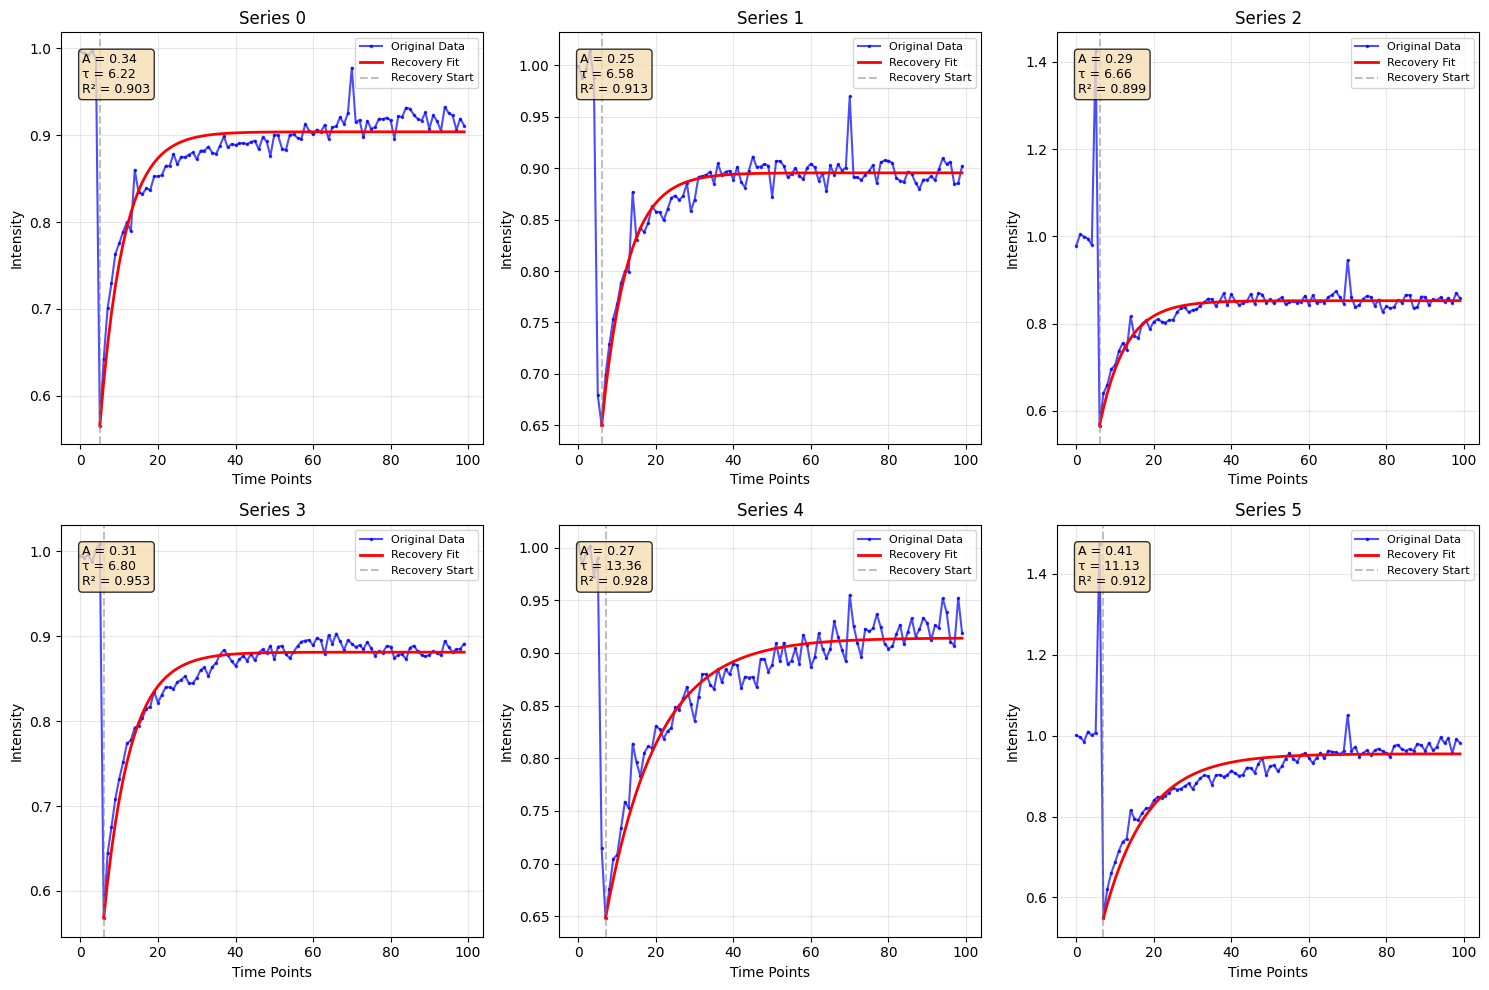

In [67]:
# Fit the recovery functions
results = fit_recovery_function(
    bleach_corrected, 
    return_stats=True, 
    plot_results=True
)
    
# Print summary
summarize_fits(results)
    
# Show individual series details
print("\nDetailed Results for First 3 Series:")
for i in range(min(3, len(results))):
    series_key = f'series_{i}'
    if series_key in results and 'error' not in results[series_key]:
        result = results[series_key]
        print(f"\nSeries {i}:")
        print(f"  Plateau (A): {result['A']:.3f} ± {result['parameter_errors'][0]:.3f}")
        print(f"  Time constant (τ): {result['tau']:.3f} ± {result['parameter_errors'][1]:.3f}")
        print(f"  Recovery starts at index: {result['min_index']}")
        print(f"  Minimum intensity: {result['min_intensity']:.3f}")
        print(f"  R²: {result['r_squared']:.4f}")

plt.show()